# MF815 Final Project

From the NLP application in class, we have two datasets: 
1) a collection of mutual fund summaries,
2) a CSV form on “Mutual Fund Labels”. In the later file, there is a column on “Investment Strategy”. There are 4 main types: “Balanced Fund (Low Risk)”, “Fixed Income Long Only (Low Risk)”, “Equity Long Only (Low Risk)”, and Long Short Funds (High Risk), excluding one other type with only one fund.

### Goal of this project is to use the mutual fund text summaries to predict which investment strategy each fund uses.

In [746]:
# Import the libraries

import os
import sys
from IPython.display import HTML, display

import numpy as np
import pandas as pd
import tensorflow as tf
from math import ceil
from scipy.spatial.distance import cosine

import matplotlib.pyplot as plt
import seaborn as sns

import collections
import random
import time
import string
import re

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, Dense, Convolution1D, MaxPooling1D, GlobalMaxPooling1D, Flatten, Dropout, LSTM, Bidirectional
from keras.regularizers import l2

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\12451\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\12451\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\12451\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


nltk.corpus.reader.wordlist.WordListCorpusReader

In [4]:
# We now set the directory to access the data
def find(name, path):
    for root, dirs, files in os.walk(path):
        if name in files:
            return os.path.join(root, name)
'''
# The folder with the data and this script should be saved in your drive.
script_name = 'CourseWork_v2.ipynb'
script_path = find(script_name, '/content/gdrive/My Drive')
DIRECTORY = '.'#os.path.dirname(script_path)
# DIRECTORY = '/content/gdrive/My Drive/'+'path of the folder that contains this script'
# If your Drive is too large and the "find" function takes to much time, you can set the directory manually :
'''

glove_word2vec = 'glove.6B.50d.txt'
our_word2vec = 'word2vec_perso.txt'

In [31]:
os.chdir(r'C:\Users\12451\OneDrive\桌面\BU\2023 Spring\ML\FinalProject')
SUMMARY_PATH = r'C:\Users\12451\OneDrive\桌面\BU\2023 Spring\ML\FinalProject\Data\MutualFundSummary'
SUMMARY_LABELS_PATH = r'C:\Users\12451\OneDrive\桌面\BU\2023 Spring\ML\FinalProject\Data\MutualFundLabels.csv'

In [209]:
# Progress bar
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

# read the repo in PATH and append the texts in a list
def get_data(PATH):
    list_dir = os.listdir(PATH)
    texts = []
    fund_names = []
    out = display(progress(0, len(list_dir)-1), display_id=True)
    for ii, filename in enumerate(list_dir) :
        with open(PATH+'/'+filename, 'r', encoding="utf8") as f :
            txt = f.read()
            try :
                txt_split = txt.split('<head_breaker>')
                summary = txt_split[1].strip()
                fund_name = txt_split[0].strip()
            except :
                summary = txt
                fund_name = ''
        texts.append(summary)
        fund_names.append(fund_name)
        out.update(progress(ii, len(list_dir)-1))
    return fund_names, texts

# Save a word2vec dictionary.
def save_word2vec(filename):
    with open(os.path.join(r'C:\Users\12451\OneDrive\桌面\BU\2023 Spring\ML\FinalProject', filename),'a' , encoding='utf-8') as f :
        for k, v in word2vec.items():
            line = k+' '+str(list(v)).strip('[]').replace(',','')+'\n'
            f.write(line)

# Load a word2vec dictionary.
def load_word2vec(filename):
    word2vec = {}
    with open(os.path.join(r'C:\Users\12451\OneDrive\桌面\BU\2023 Spring\ML\FinalProject', filename), encoding='utf8') as f:
        for line in f:
            try :
                values = line.split()
                word = values[0]
                vec = np.asarray(values[1:], dtype='float32')
                word2vec[word] = vec
            except :
                None
    return word2vec

### Read Summaries, x

In [116]:
fund_names, summaries = get_data(SUMMARY_PATH)

### Read Labels, y

In [581]:
# Read labels, y
df_label = pd.read_csv(SUMMARY_LABELS_PATH)
df_label.columns = df_label.columns.str.replace('Ivestment Strategy', 'Investment_Strategy')

investment_strategy_count = df_label['Investment_Strategy'].value_counts()
investment_strategy_count

Equity Long Only (Low Risk)          248
Fixed Income Long Only (Low Risk)    130
Balanced Fund (Low Risk)              84
Long Short Funds (High Risk)           4
Commodities Fund (Low Risk)            1
Name: Investment_Strategy, dtype: int64

In [582]:
#delete commodities fund
investment_strategy_to_delete = 'Commodities Fund (Low Risk)'
df_label = df_label[df_label['Investment_Strategy'] != investment_strategy_to_delete]
df_label['Investment_Strategy'].value_counts()

Equity Long Only (Low Risk)          248
Fixed Income Long Only (Low Risk)    130
Balanced Fund (Low Risk)              84
Long Short Funds (High Risk)           4
Name: Investment_Strategy, dtype: int64

In [590]:
df_extraction = pd.DataFrame({'fund_name' : fund_names, 'summary':summaries})
df_label = pd.read_csv(SUMMARY_LABELS_PATH)
df = df_label.merge(df_extraction, on='fund_name', how='left').dropna()
df.head()

,id,fund_name,Performance fee?,Ivestment Strategy,Leverage?,Portfolio composition,Concentration,summary
0,0000051931-18-000151,American Funds College 2018 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2018 Fund\n\nInvestment...
1,0000051931-18-000151,American Funds College 2021 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2021 Fund\n\nInvestment...
2,0000051931-18-000151,American Funds College 2024 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2024 Fund\n\nInvestment...
3,0000051931-18-000151,American Funds College 2027 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2027 Fund\n\nInvestment...
4,0000051931-18-000151,American Funds College 2030 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2030 Fund\n\nInvestment...


In [591]:
df['Ivestment Strategy'].value_counts()

Equity Long Only (Low Risk)          247
Fixed Income Long Only (Low Risk)    130
Balanced Fund (Low Risk)              84
Long Short Funds (High Risk)           4
Commodities Fund (Low Risk)            1
Name: Ivestment Strategy, dtype: int64

In [592]:
# Delete Commodities Fund 
investment_strategy_to_delete = 'Commodities Fund (Low Risk)'
df = df[df['Ivestment Strategy'] != investment_strategy_to_delete]
df['Ivestment Strategy'].value_counts()

Equity Long Only (Low Risk)          247
Fixed Income Long Only (Low Risk)    130
Balanced Fund (Low Risk)              84
Long Short Funds (High Risk)           4
Name: Ivestment Strategy, dtype: int64

In [593]:
df.shape, df.columns

((465, 8),
 Index(['id', 'fund_name', 'Performance fee?', 'Ivestment Strategy',
        'Leverage?', 'Portfolio composition', ' Concentration', 'summary'],
       dtype='object'))

In [594]:
set(df['Ivestment Strategy'])

{'Balanced Fund (Low Risk)',
 'Equity Long Only (Low Risk)',
 'Fixed Income Long Only (Low Risk)',
 'Long Short Funds (High Risk)'}

In [595]:
y = []
label = list(set(df['Ivestment Strategy']))
for i in df['Ivestment Strategy']:
    if i == label[0]:
        y.append(0)
    elif i == label[1]:
        y.append(1)
    elif i == label[2]:
        y.append(2)
    else:
        y.append(3)
df['Ivestment Strategy'] = y
df.head()

,id,fund_name,Performance fee?,Ivestment Strategy,Leverage?,Portfolio composition,Concentration,summary
0,0000051931-18-000151,American Funds College 2018 Fund,None,3,Yes,Investment grade securities,Diversified,American Funds College 2018 Fund\n\nInvestment...
1,0000051931-18-000151,American Funds College 2021 Fund,None,3,Yes,Investment grade securities,Diversified,American Funds College 2021 Fund\n\nInvestment...
2,0000051931-18-000151,American Funds College 2024 Fund,None,3,Yes,Investment grade securities,Diversified,American Funds College 2024 Fund\n\nInvestment...
3,0000051931-18-000151,American Funds College 2027 Fund,None,3,Yes,Investment grade securities,Diversified,American Funds College 2027 Fund\n\nInvestment...
4,0000051931-18-000151,American Funds College 2030 Fund,None,3,Yes,Investment grade securities,Diversified,American Funds College 2030 Fund\n\nInvestment...


In [596]:
df['Ivestment Strategy'].value_counts()

1    247
0    130
3     84
2      4
Name: Ivestment Strategy, dtype: int64

# 1. Train-test split

In [599]:
x = list(df['summary'])
len(x), len(y)

(465, 465)

In [600]:
# Training+validation and testing set
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=42)
len(X_train), len(X_test)

(372, 93)

## Data preprocessing

### Tokenize

In [601]:
# Removes the stopwords, the tokens with no letters and returns a list of the remining tokens.
# clean and tokenize the text -> we don't want to lemmatize
def tokenizer(txt):
    txt = txt.replace('\n', ' ').replace('\t', ' ').lower()
    word_tokens = word_tokenize(txt)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    filtered_sentence = [w for w in filtered_sentence if re.sub("[^A-Za-z ]+",'',w) != ''] 
    return filtered_sentence

In [602]:
stop_words = set(stopwords.words("english")+list(string.punctuation)+['``',"''"]+["]","[","*"]+['doe', 'ha', 'wa'])

In [603]:
text_words = np.concatenate([tokenizer(summary) for summary in X_train])

In [555]:
text_words[:10]

array(['summary', 'fund', 'investment', 'objective', 'columbia',
       'small/mid', 'cap', 'value', 'fund', 'fund'], dtype='<U44')

In [604]:
# Training Parameters
batch_size = 128 # The model will be trained batch per batch and one batch contains 128 rows
num_epochs = 2 # The model will go through all the data twice

In [605]:
# Word2Vec Parameters
embedding_size = 50 # Dimension of the embedding vector
max_vocabulary_size = 5000 # Total number of different words in the vocabulary
min_occurrence = 2 # Remove all words that does not appears at least n times
skip_window = 3 # How many words to consider left and right
num_skips = 4 # How many times to reuse an input to generate a label

In [606]:
# Build the dictionary and replace rare words with UNK token
count = [('UNK', -1)]
# Retrieve the most common words
count.extend(collections.Counter(text_words).most_common(max_vocabulary_size - 1))
# Remove samples with less than 'min_occurrence' occurrences
for i in range(len(count) - 1, -1, -1):
    if count[i][1] < min_occurrence:
        count.pop(i)
    else:
        # The collection is ordered, so stop when 'min_occurrence' is reached
        break

In [607]:
word2id = dict()
for i, (word, _)in enumerate(count):
    word2id[word] = i
id2word = dict(zip(word2id.values(), word2id.keys()))
vocab_size = len(id2word)

In [608]:
print ('size of the vocabulary : '+str(vocab_size))

size of the vocabulary : 5000


In [609]:
# create data
data = list()
unk_count = 0
for word in text_words:
    # Retrieve a word id, or assign it index 0 ('UNK') if not in dictionary
    index = word2id.get(word, 0)
    if index == 0:
        unk_count += 1
    data.append(index)
count[0] = ('UNK', unk_count)

In [610]:
print(data[:20])

[281, 13, 214, 125, 107, 1, 3, 358, 660, 2510, 214, 125, 1, 339, 273, 165, 358, 993, 2453, 93]


In [611]:
# build OneHot vector from index
def to_one_hot(data_point_index, vocab_size):
    temp = np.zeros(vocab_size)
    temp[data_point_index] = 1
    return temp

In [612]:
# Generate training batch for the skip-gram model
def batch_generator(batch_size, num_skips, skip_window, vocab_size):
    data_index = 0
    while True :
        assert batch_size % num_skips == 0
        assert num_skips <= 2 * skip_window
        # batch is filled with 128 inputs
        batch = np.ndarray(shape=(batch_size), dtype=np.int32)
        # labels is filled with 128 outputs 
        labels = np.ndarray(shape=(batch_size), dtype=np.int32)
        span = 2 * skip_window + 1
        # buffer keep track of the visited indexes visited
        buffer = collections.deque(maxlen=span)
        if data_index + span > len(data):
            data_index = 0
            # We stop the loop when we went through all the corpus
            break
        buffer.extend(data[data_index:data_index + span])
        data_index += span
        for i in range(batch_size // num_skips):  
            # Take the context current word
            context_words = [w for w in range(span) if w != skip_window]
            # Randomly select num_skips words in the context
            words_to_use = random.sample(context_words, num_skips)
            for j, context_word in enumerate(words_to_use):
                # Creates one raw data
                batch[i * num_skips + j] = buffer[skip_window]
                labels[i * num_skips + j] = buffer[context_word]
            if data_index == len(data):
                buffer.extend(data[0:span])
                data_index = span
            else:
                buffer.append(data[data_index])
                data_index += 1
        # Backtrack a little bit to avoid skipping words in the end of a batch
        data_index = (data_index + len(data) - span) % len(data)

        # translate word index to on-hot representation
        batch_one_hot = np.array([to_one_hot(b, vocab_size) for b in batch])
        labels_one_hot = np.array([to_one_hot(l, vocab_size) for l in labels])

        # output one batch
        yield batch_one_hot, labels_one_hot

# Train Skip-gram model

In [613]:
# Create en compile the Autoencoder
def creat_word2vec_model():
    input_word = Input(shape=(vocab_size,))

    encoded = Dense(embedding_size, activation='linear')(input_word)
    decoded = Dense(vocab_size, activation='softmax')(encoded)

    # The autoencoder is the whole model with hidden layer contected to the output layer.
    autoencoder = Model(input_word, decoded)
    # The encoder is just the input layer connected to the hidden layer. One the Autoencoder will be trained we will use
    # the encoder to create our word vectors 
    encoder = Model(input_word, encoded)
    
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return encoder, autoencoder

In [614]:
# We create the model
encoder, autoencoder = creat_word2vec_model()

In [615]:
autoencoder.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 5000)]            0         
                                                                 
 dense_10 (Dense)            (None, 50)                250050    
                                                                 
 dense_11 (Dense)            (None, 5000)              255000    
                                                                 
Total params: 505,050
Trainable params: 505,050
Non-trainable params: 0
_________________________________________________________________


In [616]:
# Finally we can train the model by feeding it with our batch generator !
autoencoder.fit_generator(batch_generator(batch_size, num_skips, skip_window, vocab_size), steps_per_epoch=ceil(len(data) / batch_size), epochs=num_epochs)

Epoch 1/2


C:\Users\12451\AppData\Local\Temp/ipykernel_16484/1429867129.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  autoencoder.fit_generator(batch_generator(batch_size, num_skips, skip_window, vocab_size), steps_per_epoch=ceil(len(data) / batch_size), epochs=num_epochs)
C:\Users\12451\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\data\ops\structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


5224/5224 [==============================] - 385s 74ms/step - loss: 0.0168
Epoch 2/2
5224/5224 [==============================] - 377s 72ms/step - loss: 0.0015


### Use encoder to Vectorize

In [618]:
# Create the Vectorizer function (prediciton of the encoder)
def vecotrize(word):
    word_one_hot = to_one_hot(word2id[word], vocab_size)
    return encoder.predict(np.array([word_one_hot]))[0]

In [619]:
# Create the word2vec dictionary
word2vec = {w : vecotrize(w) for w in word2id.keys()}

# This dictionary gives for all words it's vectorial representation.

1/1 [==============================] - 0s 21ms/step


In [620]:
save_word2vec('word2vec_815.txt')

# 3. Build 4 Knowledge Bases

## 3.1 Key words selection

In [621]:
def lemma_tokenizer(text):
    lemmatizer=WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in word_tokenize(text.replace("'"," "))]

In [623]:
# Get 4 lists of summaries of different classes
train_label0 = []
train_label1 = []
train_label2 = []
train_label3 = []
train_y0 = []
train_y1 = []
train_y2 = []
train_y3 = []
for i in range(len(X_train)):
    if y_train[i] == 0:
        train_label0.append(X_train[i])
        train_y0.append(0)
    elif y_train[i] == 1:
        train_label1.append(X_train[i])
        train_y1.append(1)
    elif y_train[i] == 2:
        train_label2.append(X_train[i])
        train_y2.append(2)
    else:
        train_label3.append(X_train[i])
        train_y3.append(3)

In [624]:
len(train_label0) + len(train_label1) + len(train_label2) + len(train_label3) - len(X_train)

0

In [657]:
stop_words = list(set(stopwords.words("english")+list(string.punctuation)+['``',"''"]+["]","[","*"]+['doe', 'ha', 'wa'] + ['1']))

#### Use tfidf to select common words in the summaries of the different classes

In [658]:
max_features = 50 # Extract the top 50 common words 
tfidf = TfidfVectorizer(input='content', tokenizer=lemma_tokenizer, stop_words=stop_words, max_features=max_features)

In [659]:
tfidf_train0 = tfidf.fit_transform(train_label0)
words0 = list(tfidf.get_feature_names_out())
len(words0), words0[:2]

(50, ['account', 'also'])

In [660]:
tfidf_train1 = tfidf.fit_transform(train_label1)
words1 = list(tfidf.get_feature_names_out())
len(words1), words1[:2]

(50, ['account', 'annual'])

In [661]:
tfidf_train2 = tfidf.fit_transform(train_label2)
words2 = list(tfidf.get_feature_names_out())
len(words2), words2[:2]

(50, ['asset', 'change'])

In [662]:
tfidf_train3 = tfidf.fit_transform(train_label3)
words3 = list(tfidf.get_feature_names_out())
len(words3), words3[:2]

(50, ['account', 'adviser'])

#### For each group of words, select the most common 10 words that appear at most 1 time other classes 

In [664]:
all_words = words0 + words1 + words2 + words3
keyword0 = []
keyword1 = []
keyword2 = []
keyword3 = []

for i in range(50):
    if all_words.count(words0[i]) <= 2:
        keyword0.append(words0[i])
    if len(keyword0) == 10:
        break
        
for i in range(50):
    if all_words.count(words1[i]) <= 2:
        keyword1.append(words1[i])
    if len(keyword1) == 10:
        break
        
for i in range(50):
    if all_words.count(words2[i]) <= 2:
        keyword2.append(words2[i])
    if len(keyword2) == 10:
        break
        
for i in range(50):
    if all_words.count(words3[i]) <= 2:
        keyword3.append(words3[i])
    if len(keyword3) == 10:
        break

keyword0, keyword1, keyword2, keyword3

(['also',
  'bond',
  'credit',
  'debt',
  'derivative',
  'federal',
  'higher',
  'income',
  'information',
  'instrument'],
 ['charge',
  'country',
  'economic',
  'example',
  'foreign',
  'higher',
  'index',
  'information',
  'intermediary',
  'invest'],
 ['commodity',
  'country',
  'currency',
  'decline',
  'derivative',
  'dreyfus',
  'equity',
  'estate',
  'fixed-income',
  'foreign'],
 ['adviser',
  'allocation',
  'also',
  'bond',
  'capital',
  'could',
  'debt',
  'income',
  'index',
  'investor'])

# 3. Create Knowledge Base

In [666]:
def get_n_closer(w, n, word2vec):
    vect = word2vec[w]
    distances_dict = {k: cosine(v, vect) for k, v in word2vec.items()}
    
    closer_words = []
    for _ in range(n):
        min_key = min(distances_dict.keys(), key=lambda k: distances_dict[k])
        closer_words.append(min_key)
        del distances_dict[min_key]
    return closer_words

# Creates the knwoledge base by taking the num_neighbors closes neighbors of each key_words in word2vec
def create_knowledge_base(num_neighbors, word2vec, key_words):
    knowledge_base = set()
    out = display(progress(0, len(key_words)-1), display_id=True)
    for ii, key_word in enumerate(key_words) :
        knowledge_base.add(key_word)
        neighbors = []
        try :
            neighbors = get_n_closer(key_word, num_neighbors, word2vec)
        except :
            print(key_word + ' not in word2vec')

        knowledge_base.update(neighbors)
        
        out.update(progress(ii, len(key_words)-1))
    return knowledge_base

In [668]:
#word2vec = load_word2vec(our_word2vec)
knowledge_base0 = create_knowledge_base(5, word2vec, keyword0)
knowledge_base1 = create_knowledge_base(5, word2vec, keyword1)
knowledge_base2 = create_knowledge_base(5, word2vec, keyword2)
knowledge_base3 = create_knowledge_base(5, word2vec, keyword3)

In [669]:
print(knowledge_base0)

{'formerly', 'also', 'credit', 'use', 'income', 'assistant', 'pursuant', 'bond', 'relief', 'structuring', 'nonrecurring', 'counterparty', 'dependence', 'derivative', 'existing', 'debt', 'higher', 'magnifying', 'excludable', 'flow', 'mid-sized', 'greater', 'plus', 'affecting', 'netherlands', 'address', 'supporting', 'vice', 'columbiathreadneedleus.com', 'breaches', 'information', 'priced', 'marketing', 'ms.', 'acquire', 'effected', 'reflected', 'dollar-weighted', 'commodity', 'rebalance', 'firm', 'instrument', 'manager/analyst', 'various', 'exploration', 'federal', 'standard', 'frameworks', 'g.', 'lynch'}


# 4. Select sentences by distance and Classification

## 4.1 Select sentences

In [673]:
# Takes a summary, the knowledge base and some hyper parameters and returns the "num_sent" sentences
# of the summary that are closer to the the knowledge base in term of spacial distances.
def extract_sentence_distance(summary, knowledge, n_closer, n_reject, num_sent):
    # Split the summary into sentences.
    sentences = sent_tokenize(summary)
    sentence_scores = []
    # Loop over the sentences.
    for j, sentence in enumerate(sentences):
        # we tokenize and clean the sentence
        tokens = tokenizer(sentence)

        sentence_barycentre = np.zeros(embedding_size)
        effective_len = 0
        # Compute the barycentre of the sentence
        for token in tokens :
            try :
                sentence_barycentre += np.array(word2vec[token])
                effective_len += 1
            except KeyError :
                pass
            except :
                raise
        
        # Reject sentences with less than n_reject words in our word2vec map
        if effective_len <= n_reject :
            sentence_scores.append(1)    

        else :
            sentence_barycentre = sentence_barycentre/effective_len
            # Compute the distance sentece_barycentre -> words in our knowledge base
            barycentre_distance = [cosine(sentence_barycentre, word2vec[key_word]) for key_word in knowledge]
            barycentre_distance.sort()
            # Create the score of the sentence by averaging the "n_closer" smallest distances
            score = np.mean(barycentre_distance[:n_closer])
            sentence_scores.append(score)
    # Select the "num_sent" sentences that have the smallest score (smallest distance score with the knowledge base)
    sentence_scores, sentences = zip(*sorted(zip(sentence_scores, sentences)))
    top_sentences = sentences[:num_sent]
    return ' '.join(top_sentences)
    #return sum(sentence_scores[:num_sent])

In [675]:
len(X_train), type(X_train)

(372, list)

In [872]:
# For each summary, select 5 sentences for each knowledge base. Then combine those sentences together. (20 sentences in total)
selected_sentences = []
knowledge_bases_l = [knowledge_base0, knowledge_base1, knowledge_base2, knowledge_base3]
for i in range(len(X_train)):
    temp = ''
    for j in range(4):
        temp += extract_sentence_distance(X_train[i], knowledge_bases_l[j], n_closer=10, n_reject=5, num_sent=5)
    selected_sentences.append(temp)

selected_sentences_Xtest = []
for i in range(len(X_test)):
    temp = ''
    for j in range(4):
        temp += extract_sentence_distance(X_test[i], knowledge_bases_l[j], n_closer=10, n_reject=5, num_sent=5)
    selected_sentences_Xtest.append(temp)

In [873]:
len(selected_sentences), len(X_train), type(selected_sentences_Xtest), len(selected_sentences_Xtest)

(372, 372, list, 93)

# 4.2 Classification

In [925]:
X = [' '.join(tokenizer(txt)) for txt in selected_sentences]
X[0][:100]

'governments countries may less stable likely impose capital controls nationalize company industry pl'

In [926]:
y = y_train[:]
len(X) , len(y)

(372, 372)

In [927]:
X_train_CNN, X_test_CNN, y_train_CNN, y_test_CNN = train_test_split(X, y, test_size = 0.2, random_state=42)

C:\Users\12451\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\12451\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:>

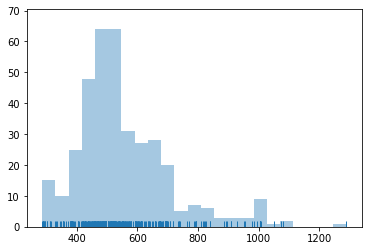

In [902]:
# In order to set the length of the document series (maxlen), we visualise the distribution of the number of words per documents.
sizes = []
out = display(progress(0, len(X)), display_id=True)
for ii, txt in enumerate(X):
    sizes.append(len(word_tokenize(txt)))
    out.update(progress(ii, len(X)))

sns.distplot(sizes, kde=False, rug=True)

In [950]:
num_words = 300 # Size of the vocabulary used. we only consider the 2500 most common words. The other words are removed from the texts.
maxlen = 1000 # Number of word considered for each document. we cut or lengthen the texts to have texts of 150 words.
word_dimension = 50 # dimension of our word vectors.

In [951]:
# The Tokenizer provided by the Keras library allows to perform such transformation.
keras_tokenizer = Tokenizer(num_words=num_words)
keras_tokenizer.fit_on_texts(X_train_CNN)
# word_index is the dictionary that contains the index of each words in our 2500 long vocabulary.
word_index = keras_tokenizer.word_index
sequences_train = keras_tokenizer.texts_to_sequences(X_train_CNN)
sequences_test = keras_tokenizer.texts_to_sequences(X_test_CNN)

In [952]:
feature_train = pad_sequences(sequences_train, maxlen=maxlen, dtype=float, padding='post', truncating='post')
feature_test = pad_sequences(sequences_test, maxlen=maxlen, dtype=float, padding='post', truncating='post')

In [953]:
embedding_matrix = np.zeros((len(word_index) + 1, word_dimension))
for word, i in word_index.items():
    embedding_vector = word2vec.get(word)
    #embedding_vector = word2vec.get(word)   # uncomment to use our own word2vec
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

## 4.2 Build CNN models

In [928]:
def create_CNN_model():
    CNN = Sequential()
    # The Embedding layer takes the embedding matrix as an argument and transform the inputed the sequences of index to sequences of vectors.
    CNN.add(Embedding(len(word_index) + 1, word_dimension, weights=[embedding_matrix], input_length = maxlen, trainable=False))

    CNN.add(Convolution1D(64, 5, activation = 'relu'))
    CNN.add(MaxPooling1D(pool_size = 5))
    
    CNN.add(Convolution1D(32, 5, activation = 'relu'))
    CNN.add(MaxPooling1D(pool_size = 5))

    CNN.add(Flatten())
    CNN.add(Dense(units = 128 , activation = 'relu'))
    CNN.add(Dropout(0.5))
    CNN.add(Dense(units = 4, activation = 'sigmoid'))

    CNN.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return CNN

In [930]:
labels = np.array(y_train_CNN)
vectorized_y_train = np.array(np.eye(4)[labels])
labels = np.array(y_test_CNN)
vectorized_y_test = np.array(np.eye(4)[labels])
len(vectorized_y_train), vectorized_y_train[0], len(vectorized_y_test), vectorized_y_test[0]

(297, array([1., 0., 0., 0.]), 75, array([0., 1., 0., 0.]))

In [931]:
tf.config.run_functions_eagerly(True)

In [932]:
CNN_model = create_CNN_model()
# all inputs should be np.array
CNN_history = CNN_model.fit(feature_train, vectorized_y_train, epochs=10, batch_size=16, \
                            validation_data=(feature_test, vectorized_y_test))

Epoch 1/10
19/19 [==============================] - 2s 97ms/step - loss: 0.5324 - accuracy: 0.3973 - val_loss: 0.4632 - val_accuracy: 0.5733
Epoch 2/10
19/19 [==============================] - 2s 101ms/step - loss: 0.4550 - accuracy: 0.5286 - val_loss: 0.4639 - val_accuracy: 0.5733
Epoch 3/10
19/19 [==============================] - 2s 104ms/step - loss: 0.4376 - accuracy: 0.4848 - val_loss: 0.4095 - val_accuracy: 0.6000
Epoch 4/10
19/19 [==============================] - 2s 99ms/step - loss: 0.4347 - accuracy: 0.5556 - val_loss: 0.4018 - val_accuracy: 0.6000
Epoch 5/10
19/19 [==============================] - 2s 98ms/step - loss: 0.3955 - accuracy: 0.6397 - val_loss: 0.3959 - val_accuracy: 0.6933
Epoch 6/10
19/19 [==============================] - 2s 99ms/step - loss: 0.3727 - accuracy: 0.6667 - val_loss: 0.3670 - val_accuracy: 0.7200
Epoch 7/10
19/19 [==============================] - 2s 95ms/step - loss: 0.3376 - accuracy: 0.7071 - val_loss: 0.3605 - val_accuracy: 0.6800
Epoch 8/10


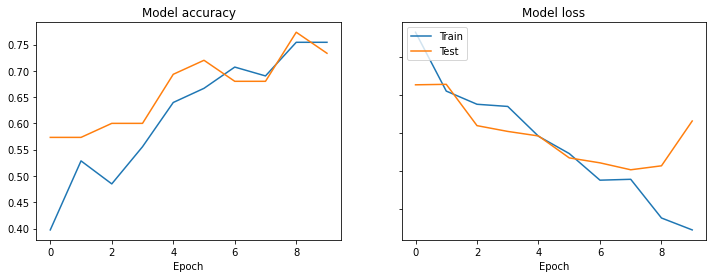

In [933]:
# Plot training & validation accuracy
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
axs[0].plot(CNN_history.history['accuracy'])
axs[0].plot(CNN_history.history['val_accuracy'])
axs[0].set_title('Model accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
# Plot training & validation loss values
axs[1].plot(CNN_history.history['loss'])
axs[1].plot(CNN_history.history['val_loss'])
axs[1].set_title('Model loss')
plt.legend(['Train', 'Test'], loc='upper left')

for ax in axs.flat:
    ax.set(xlabel='Epoch')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [954]:
def create_CNN_model():
    CNN = Sequential()
    # The Embedding layer takes the embedding matrix as an argument and transform the inputed the sequences of index to sequences of vectors.
    CNN.add(Embedding(len(word_index) + 1, word_dimension, weights=[embedding_matrix], input_length = maxlen, trainable=False))

    CNN.add(Convolution1D(96, 5, activation = 'relu'))
    CNN.add(MaxPooling1D(pool_size = 5))
    
    CNN.add(Convolution1D(48, 5, activation = 'relu'))
    CNN.add(MaxPooling1D(pool_size = 5))

    CNN.add(Flatten())
    CNN.add(Dense(units = 128 , activation = 'relu'))
    CNN.add(Dropout(0.5))
    CNN.add(Dense(units = 4, activation = 'sigmoid'))

    CNN.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return CNN

In [955]:
CNN_model = create_CNN_model()
# all inputs should be np.array
CNN_history = CNN_model.fit(feature_train, vectorized_y_train, epochs=10, batch_size=16, \
                            validation_data=(feature_test, vectorized_y_test))

Epoch 1/10
19/19 [==============================] - 2s 112ms/step - loss: 0.5215 - accuracy: 0.4680 - val_loss: 0.4388 - val_accuracy: 0.5600
Epoch 2/10
19/19 [==============================] - 2s 105ms/step - loss: 0.4677 - accuracy: 0.5185 - val_loss: 0.4247 - val_accuracy: 0.5600
Epoch 3/10
19/19 [==============================] - 2s 105ms/step - loss: 0.4300 - accuracy: 0.5623 - val_loss: 0.4046 - val_accuracy: 0.6267
Epoch 4/10
19/19 [==============================] - 2s 106ms/step - loss: 0.4180 - accuracy: 0.5926 - val_loss: 0.3844 - val_accuracy: 0.7067
Epoch 5/10
19/19 [==============================] - 2s 107ms/step - loss: 0.3921 - accuracy: 0.6566 - val_loss: 0.3752 - val_accuracy: 0.6800
Epoch 6/10
19/19 [==============================] - 2s 105ms/step - loss: 0.3474 - accuracy: 0.6801 - val_loss: 0.3628 - val_accuracy: 0.7067
Epoch 7/10
19/19 [==============================] - 2s 106ms/step - loss: 0.3329 - accuracy: 0.7205 - val_loss: 0.3580 - val_accuracy: 0.7067
Epoch 

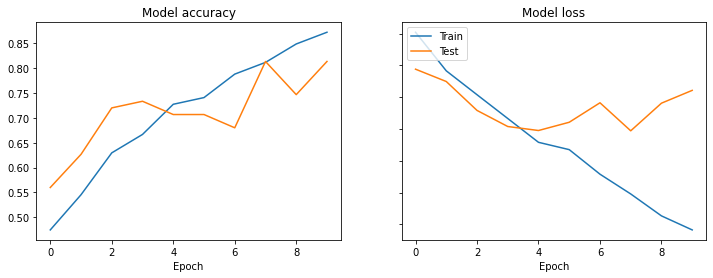

In [936]:
# Plot training & validation accuracy
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
axs[0].plot(CNN_history.history['accuracy'])
axs[0].plot(CNN_history.history['val_accuracy'])
axs[0].set_title('Model accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
# Plot training & validation loss values
axs[1].plot(CNN_history.history['loss'])
axs[1].plot(CNN_history.history['val_loss'])
axs[1].set_title('Model loss')
plt.legend(['Train', 'Test'], loc='upper left')

for ax in axs.flat:
    ax.set(xlabel='Epoch')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [937]:
def create_CNN_model():
    CNN = Sequential()
    # The Embedding layer takes the embedding matrix as an argument and transform the inputed the sequences of index to sequences of vectors.
    CNN.add(Embedding(len(word_index) + 1, word_dimension, weights=[embedding_matrix], input_length = maxlen, trainable=False))

    CNN.add(Convolution1D(128, 5, activation = 'relu'))
    CNN.add(MaxPooling1D(pool_size = 5))
    
    CNN.add(Convolution1D(64, 5, activation = 'relu'))
    CNN.add(MaxPooling1D(pool_size = 5))

    CNN.add(Flatten())
    CNN.add(Dense(units = 128 , activation = 'relu'))
    CNN.add(Dropout(0.5))
    CNN.add(Dense(units = 4, activation = 'sigmoid'))

    CNN.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return CNN

In [938]:
CNN_model = create_CNN_model()
# all inputs should be np.array
CNN_history = CNN_model.fit(feature_train, vectorized_y_train, epochs=10, batch_size=16, \
                            validation_data=(feature_test, vectorized_y_test))

Epoch 1/10
19/19 [==============================] - 3s 135ms/step - loss: 0.5166 - accuracy: 0.4444 - val_loss: 0.4508 - val_accuracy: 0.5600
Epoch 2/10
19/19 [==============================] - 3s 132ms/step - loss: 0.4441 - accuracy: 0.5152 - val_loss: 0.4244 - val_accuracy: 0.6000
Epoch 3/10
19/19 [==============================] - 2s 130ms/step - loss: 0.4290 - accuracy: 0.5286 - val_loss: 0.4044 - val_accuracy: 0.6933
Epoch 4/10
19/19 [==============================] - 2s 130ms/step - loss: 0.3916 - accuracy: 0.6566 - val_loss: 0.3645 - val_accuracy: 0.7200
Epoch 5/10
19/19 [==============================] - 2s 130ms/step - loss: 0.3586 - accuracy: 0.7104 - val_loss: 0.3552 - val_accuracy: 0.7067
Epoch 6/10
19/19 [==============================] - 2s 130ms/step - loss: 0.3266 - accuracy: 0.7071 - val_loss: 0.3644 - val_accuracy: 0.6933
Epoch 7/10
19/19 [==============================] - 2s 127ms/step - loss: 0.2990 - accuracy: 0.7306 - val_loss: 0.3553 - val_accuracy: 0.7467
Epoch 

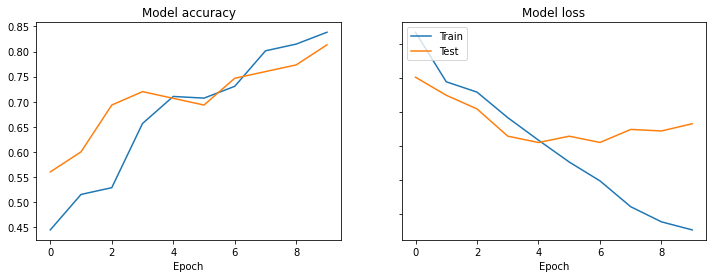

In [941]:
# Plot training & validation accuracy
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
axs[0].plot(CNN_history.history['accuracy'])
axs[0].plot(CNN_history.history['val_accuracy'])
axs[0].set_title('Model accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
# Plot training & validation loss values
axs[1].plot(CNN_history.history['loss'])
axs[1].plot(CNN_history.history['val_loss'])
axs[1].set_title('Model loss')
plt.legend(['Train', 'Test'], loc='upper left')

for ax in axs.flat:
    ax.set(xlabel='Epoch')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

# 5. Parameter Tunning

In [783]:
accuracy_l = []
val_accuracy_l = []
batch_size_l = list(range(8,20))

for size in batch_size_l:
    CNN_model = create_CNN_model
    CNN_history = CNN_model.fit(feature_train, vectorized_y_train, epochs=10, batch_size=size, \
                            validation_data=(feature_test, vectorized_y_test))
    accuracy_l.append(CNN_history.history['accuracy'])
    val_accuracy_l.append(CNN_history.history['val_accuracy'])

Epoch 1/10
38/38 [==============================] - 5s 122ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 1.5191 - val_accuracy: 0.7200
Epoch 2/10
38/38 [==============================] - 4s 110ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.5363 - val_accuracy: 0.7067
Epoch 3/10
38/38 [==============================] - 4s 109ms/step - loss: 0.0115 - accuracy: 0.9933 - val_loss: 1.4890 - val_accuracy: 0.6667
Epoch 4/10
38/38 [==============================] - 4s 109ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 1.5201 - val_accuracy: 0.6800
Epoch 5/10
38/38 [==============================] - 4s 113ms/step - loss: 0.0133 - accuracy: 0.9966 - val_loss: 1.3965 - val_accuracy: 0.7067
Epoch 6/10
38/38 [==============================] - 4s 110ms/step - loss: 0.0092 - accuracy: 0.9966 - val_loss: 1.4439 - val_accuracy: 0.7067
Epoch 7/10
38/38 [==============================] - 4s 110ms/step - loss: 0.0135 - accuracy: 0.9899 - val_loss: 1.3464 - val_accuracy: 0.7067
Epoch 

In [800]:
len(accuracy_l)

12

<Figure size 1152x288 with 0 Axes>

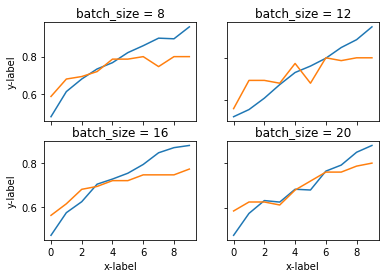

In [855]:
plt.figure(figsize=(16, 4))
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(accuracy_l[0])
axs[0, 0].plot(val_accuracy_l[0])
axs[0, 0].set_title('batch_size = 8')
axs[0, 1].plot(accuracy_l[4])
axs[0, 1].plot(val_accuracy_l[4])
axs[0, 1].set_title('batch_size = 12')
axs[1, 0].plot(accuracy_l[8])
axs[1, 0].plot(val_accuracy_l[8])
axs[1, 0].set_title('batch_size = 16')
axs[1, 1].plot(accuracy_l[11])
axs[1, 1].plot(val_accuracy_l[11])
axs[1, 1].set_title('batch_size = 20')

for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [942]:
max_val_acc = 0
ind = 0
best_epoch = 0
c = 0
for i in val_accuracy_l:
    c += 1
    if max(i) > max_val_acc:
        max_val_acc = max(i)
        best_epoch = i.index(max(i))
        best_batch = batch_size_l[c]
print('max_val_accuracy: ', max_val_acc)
print('best epoch: ', best_epoch)
print('best_batch: ', best_batch)

max_val_accuracy:  0.8266666531562805
best epoch:  5
best_batch:  10


# 6. Predict test set

In [945]:
vectorized_y_test6 = np.array(np.eye(4)[np.array(y_test)])

In [956]:
keras_tokenizer.fit_on_texts(X_test)
word_index = keras_tokenizer.word_index
sequences_test = keras_tokenizer.texts_to_sequences(X_test) 
feature_test = pad_sequences(sequences_test, maxlen=maxlen, dtype=float, padding='post', truncating='post')
test_loss, test_acc = CNN_model.evaluate(feature_test,  vectorized_y_test6, verbose=2)

3/3 - 0s - loss: 0.9235 - accuracy: 0.4946 - 139ms/epoch - 46ms/step
